In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import urllib.request
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [2]:
list_metricas = ['average_clustering', 'coefficient_distribution_degree', 'density', 'average_degree', 'average_short_path']#, 'number_of_nodes']


list_variables_a = [
    #'Patrimonio_Liquido',
    #'Cotas_Emitidas',
    #'Valor_Patrimonial_Cotas',
    'Percentual_Rentabilidade_Efetiva_Mes',
    'Percentual_Rentabilidade_Patrimonial_Mes',
    #'Percentual_Dividend_Yield_Mes',
    #'Percentual_Amortizacao_Cotas_Mes',
]


list_variables_b = [
    'Valor_Ativo',
    'Percentual_Despesas_Taxa_Administracao',
    'Percentual_Despesas_Agente_Custodiante',
    'Total_Necessidades_Liquidez',
    'Disponibilidades',
    'Titulos_Publicos',
    'Titulos_Privados',
    'Fundos_Renda_Fixa',
    'Total_Investido',
    'Direitos_Bens_Imoveis',
    'Terrenos',
    'Imoveis_Renda_Acabados',
    'Imoveis_Renda_Construcao',
    'Imoveis_Venda_Acabados',
    'Imoveis_Venda_Construcao',
    'Outros_Direitos_Reais',
    'Acoes',
    'Debentures',
    'Bonus_Subscricao',
    'Certificados_Deposito_Valores_Mobiliarios',
    'Cedulas_Debentures',
    'Fundo_Acoes',
    'FIP',
    'FII',
    'FDIC',
    'Outras_Cotas_FI',
    'Notas_Promissorias',
    'Acoes_Sociedades_Atividades_FII',
    'Cotas_Sociedades_Atividades_FII',
    'CEPAC',
    'CRI',
    'Letras_Hipotecarias',
    'LCI',
    'LIG',
    'Outros_Valores_Mobliarios',
    'Valores_Receber',
    'Contas_Receber_Aluguel',
    'Contas_Receber_Venda_Imoveis',
    'Outros_Valores_Receber',
    'Rendimentos_Distribuir',
    'Taxa_Administracao_Pagar',
    'Taxa_Performance_Pagar',
    'Obrigacoes_Aquisicao_Imoveis',
    'Adiantamento_Venda_Imoveis',
    'Adiantamento_Alugueis',
    'Obrigacoes_Securitizacao_Recebiveis',
    'Instrumentos_Financeiros_Derivativos',
    'Provisoes_Contigencias',
    'Outros_Valores_Pagar',
    'Total_Passivo',
 ]

list_variables =  list_variables_b #list_variables_a +

list_cat = [
    'Mandato',
    'Segmento_Atuacao',
    'Publico_Alvo',
    'Tipo_Gestao',
]

ds_fii = xr.open_dataset('dataset/cvm/dataset_cvm_metrica_mensal.nc').fillna(0)
df_dados_fii = pd.read_csv('dataset/cvm/dataset_cvm_metrica_mensal_dados.csv', index_col='CNPJ_Fundo')

df_fii = ds_fii.to_array().stack(var=['variable', 'metrica']).to_pandas()

df_fii[[ (v, 'coefficient_distribution_degree') for v in list_variables ]] = df_fii[[ (v, 'coefficient_distribution_degree') for v in list_variables ]][df_fii[[ (v, 'coefficient_distribution_degree') for v in list_variables ]].apply(zscore).abs() <= 1].fillna(0)
df_fii_cat =  df_dados_fii[list_cat]

df_fii = df_fii[ [ (v, m) for v in list_variables for m in list_metricas ] ]
df_fii[['TIR']] = df_dados_fii[['TIR']][df_dados_fii[['TIR']].fillna(0).apply(zscore).abs() <= 1].fillna(0)

cnpj_meses = xr.open_dataset('dataset/cvm/dataset_cvm_metrica_mensal.nc').fillna(0).Acoes.sel(metrica='number_of_nodes').to_pandas()

In [3]:
import copy

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

In [4]:
def dataset_filter(df, tamanho_series):
    list_cnpj = cnpj_meses[cnpj_meses >= tamanho_series].index.values
    df_out = df[df.index.isin(list_cnpj)]
    
    return df_out

In [5]:
def select_features_rfr(df_fii, tamanho_series, num_test=10):
    df_fii_filter = dataset_filter(df_fii, tamanho_series)
    
    df_features = df_fii_filter.drop(columns=[('TIR', '')])
    df_target = df_fii_filter[('TIR', '')]
    
    prep = OneHotEncoder()
    prep.fit(df_dados_fii[df_dados_fii.index.isin(df_fii_filter.index.values)][list_cat])
    
    preprocessing = prep.transform(df_dados_fii[df_dados_fii.index.isin(df_fii_filter.index.values)][list_cat]).toarray()
    
    X_train, X_test, y_train, y_test = train_test_split(np.hstack((df_features, preprocessing)), df_target, train_size=2/3)
    
    rfr = RandomForestRegressor(n_estimators=X_train.shape[1]*2, n_jobs=-1)
    
    prep_cols = []
    for i in prep.categories_:
        prep_cols += list(i)
    
    prep_cols_tuple = []
    for i in prep_cols:
        prep_cols_tuple.append((i, ''))
        
    mi = pd.MultiIndex.from_tuples(list(df_features.columns.values) + prep_cols_tuple, names=('variable', 'metric'))
        
    df_features_values = pd.DataFrame(columns=mi).T
    mae_erros = []
    medae_erros = []
    
    for i in range(num_test):
        print(f'{i+1:2d}/{num_test:2d}')
        rfr.fit(X_train, y_train)
        mae_erros.append( mean_absolute_error(y_test, rfr.predict(X_test)) )
        medae_erros.append( median_absolute_error(y_test, rfr.predict(X_test)) )
        
        df_features_values[f'model_{i}'] = pd.DataFrame(data=rfr.feature_importances_, index=df_features_values.index.values, columns=[f'model_{i}'])
        
    return df_features_values.T, mae_erros, medae_erros

# Resultados

Gráfico por classificação

In [6]:
dict_data = {}

dict_data[48] = select_features_rfr(df_fii, 48, 50)

 1/50
 2/50
 3/50
 4/50
 5/50
 6/50
 7/50
 8/50
 9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50


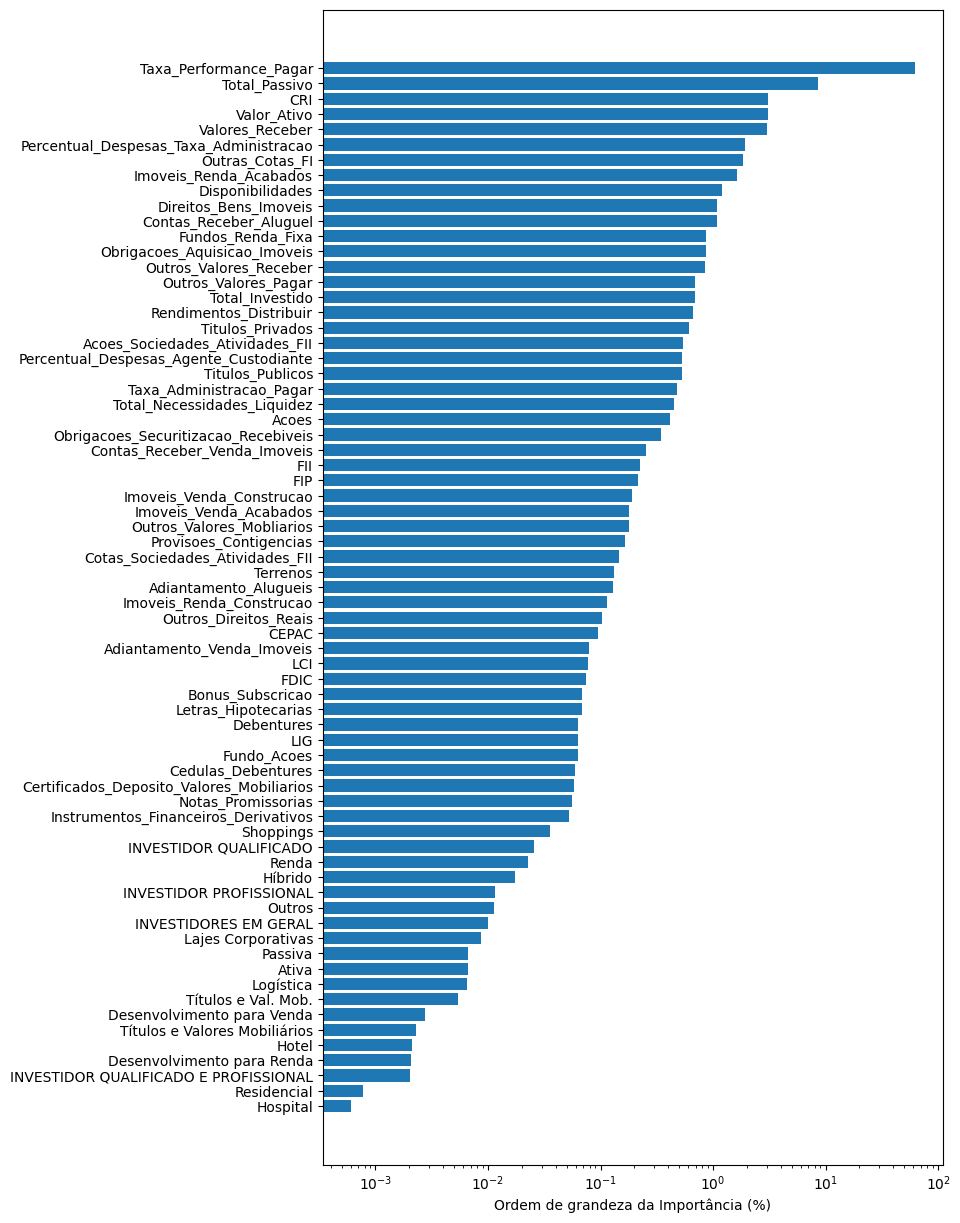

In [7]:
periodo = 48

df_plot = dict_data[periodo][0].mean().groupby(level=[0]).sum().sort_values(ascending=True)*100


plt.figure(figsize=(8,15))
plt.barh(range(df_plot.size), df_plot.values)
plt.yticks(range(df_plot.size), df_plot.index.values)
plt.xlabel('Ordem de grandeza da Importância (%)')
plt.xscale('log')
plt.show()

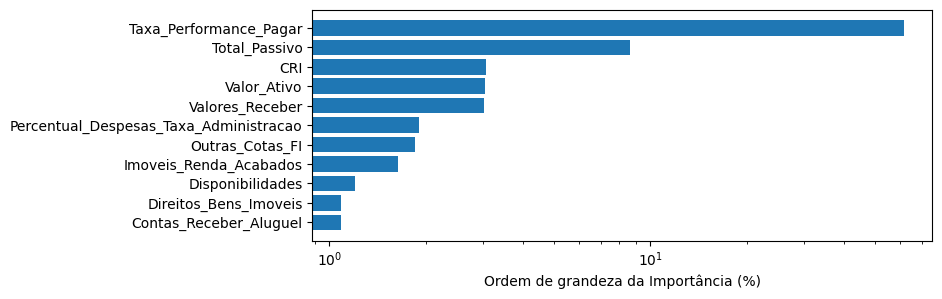

In [8]:
periodo = 48

df_plot = dict_data[periodo][0].mean().groupby(level=[0]).sum().sort_values(ascending=True)*100
df_plot = df_plot[df_plot>=1]

plt.figure(figsize=(8, df_plot.size//3))
plt.barh(range(df_plot.size), df_plot.values)
plt.yticks(range(df_plot.size), df_plot.index.values)
plt.xlabel('Ordem de grandeza da Importância (%)')
plt.xscale('log')
plt.show()

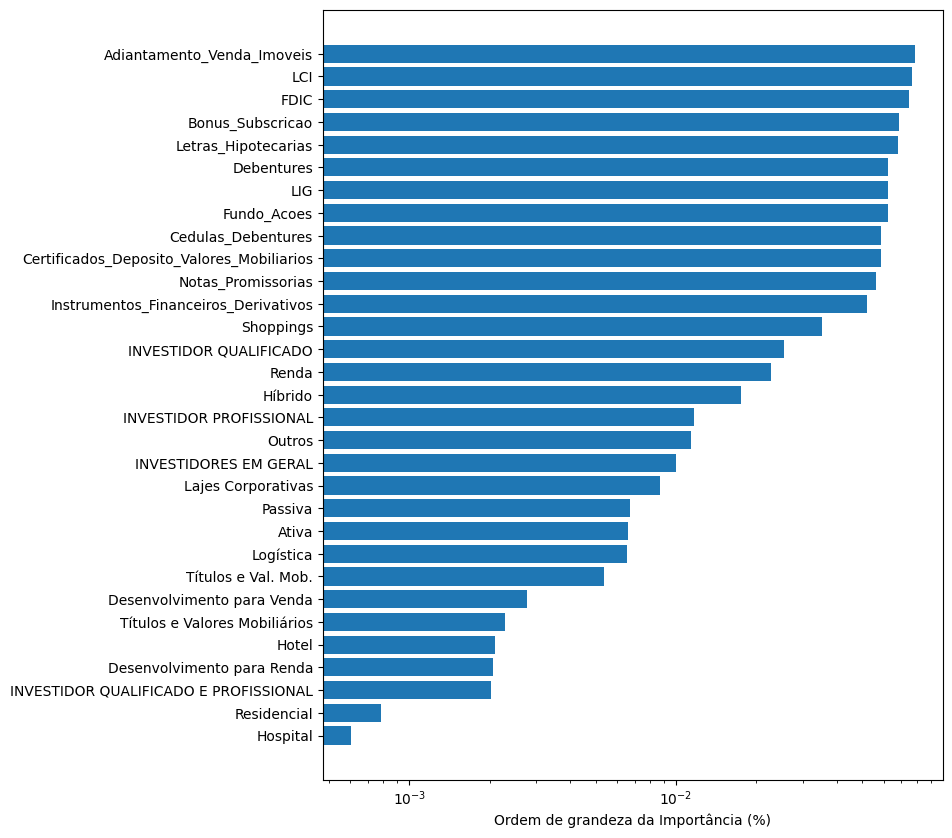

In [9]:
periodo = 48

df_plot = dict_data[periodo][0].mean().groupby(level=[0]).sum().sort_values(ascending=True)*100
df_plot = df_plot[df_plot.sort_values(ascending=True).cumsum() <= 1]

plt.figure(figsize=(8, df_plot.size//3))
plt.barh(range(df_plot.size), df_plot.values)
plt.yticks(range(df_plot.size), df_plot.index.values)
plt.xlabel('Ordem de grandeza da Importância (%)')
plt.xscale('log')
plt.show()

In [42]:
dataset_filter(df_fii, 48).shape

(367, 251)

In [15]:
from analise_fundos_imobiliarios.run import *
ds = transform_files_cvm_mensal()

In [34]:
variable = []
porcent = []

for i in df_plot.index.values:
    try:
        porcent.append(ds[i].sum(axis=1)[ds[i].sum(axis=1) != 0].size)
        variable.append(i)
    except:
        pass

df_dis = pd.DataFrame(porcent, columns=['Valor'], index=variable)

<Axes: xlabel='Porcentagem de fundo (%)'>

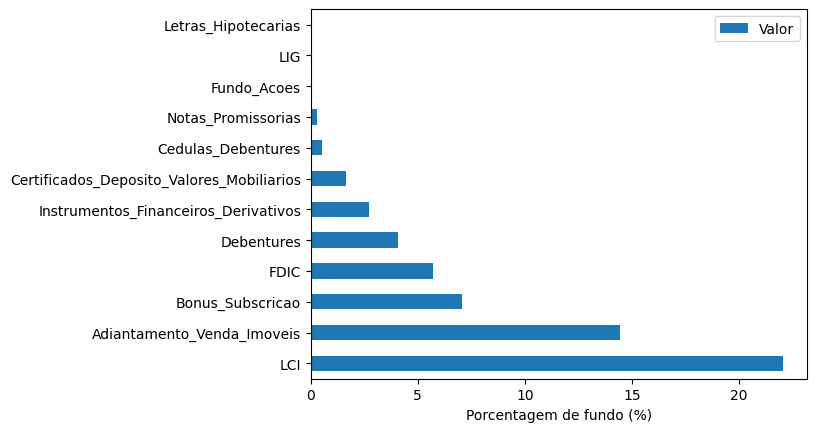

In [45]:
(100*df_dis/367).sort_values('Valor', ascending=False).plot.barh(xlabel='Porcentagem de fundo (%)')